# This script synchronizes the AUV in-situ measurements

---

#### Author: Yaolin Ge
#### Contact: yaolin.ge@ntnu.no
#### Date: 2023-06-21
---

## It consists of three steps

- Step I: extract raw data from sensor array. 
- Step II: synchronize raw data with timestamps. 
- Step III: Merge all data together

---

## Note: 
- CTD sensor has IMC ID: 78 which is hard-coded sometime. CTD sensor is "Water Quality Sensor" in Neptus from Lauv-xplore-1. 


In [1]:
import os
import re
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

datapath = "/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Data/Nidelva/20230621/TAICHI/083723_follow_ntnu/mra/csv/"


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Step I: extract raw data

In [2]:
#% Data extraction from the raw data
rawLoc = pd.read_csv(datapath + "EstimatedState.csv", delimiter=', ', header=0, engine='python')
rawSal = pd.read_csv(datapath + "Salinity.csv", delimiter=', ', header=0, engine='python')
rawTemp = pd.read_csv(datapath + "Temperature.csv", delimiter=', ', header=0, engine='python')
rawDepth = pd.read_csv(datapath + "Depth.csv", delimiter=', ', header=0, engine='python')

# To group all the time stamp together, since only second accuracy matters
rawSal.iloc[:, 0] = np.ceil(rawSal.iloc[:, 0])
rawTemp.iloc[:, 0] = np.ceil(rawTemp.iloc[:, 0])
rawCTDTemp = rawTemp[rawTemp.iloc[:, 2] == 78]
rawLoc.iloc[:, 0] = np.ceil(rawLoc.iloc[:, 0])
rawDepth.iloc[:, 0] = np.ceil(rawDepth.iloc[:, 0])
rawDepth.iloc[:, 0] = np.ceil(rawDepth.iloc[:, 0])

In [6]:
rawTemp

,timestamp (seconds since 01/01/1970),system,entity,value (°c)
0,1.687337e+09,lauv-thor,53,28.000000
1,1.687337e+09,lauv-thor,53,28.000000
2,1.687337e+09,lauv-thor,53,28.000000
3,1.687337e+09,lauv-thor,53,28.000000
4,1.687337e+09,lauv-thor,53,28.000000
...,...,...,...,...
165827,1.687345e+09,lauv-thor,71,44.437000
165828,1.687345e+09,lauv-thor,53,29.500000
165829,1.687345e+09,lauv-thor,62,18.197418
165830,1.687345e+09,lauv-thor,62,18.197418


# Step II: synchronize with timestamps

In [5]:
lat_origin = rawLoc["lat (rad)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
lon_origin = rawLoc["lon (rad)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
x_loc = rawLoc["x (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
y_loc = rawLoc["y (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
z_loc = rawLoc["z (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
depth = rawLoc["depth (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
time_loc = rawLoc["timestamp (seconds since 01/01/1970)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
time_sal= rawSal["timestamp (seconds since 01/01/1970)"].groupby(rawSal["timestamp (seconds since 01/01/1970)"]).mean()
time_temp = rawCTDTemp["timestamp (seconds since 01/01/1970)"].groupby(rawCTDTemp["timestamp (seconds since 01/01/1970)"]).mean()
dataSal = rawSal["value (psu)"].groupby(rawSal["timestamp (seconds since 01/01/1970)"]).mean()
dataTemp = rawCTDTemp.iloc[:, -1].groupby(rawCTDTemp["timestamp (seconds since 01/01/1970)"]).mean()



# Step III: merge all synchronized data

timestamp (seconds since 01/01/1970)
1.687337e+09    1.687337e+09
1.687337e+09    1.687337e+09
1.687337e+09    1.687337e+09
1.687337e+09    1.687337e+09
1.687337e+09    1.687337e+09
                    ...     
1.687345e+09    1.687345e+09
1.687345e+09    1.687345e+09
1.687345e+09    1.687345e+09
1.687345e+09    1.687345e+09
1.687345e+09    1.687345e+09
Name: timestamp (seconds since 01/01/1970), Length: 7882, dtype: float64

In [12]:
circumference = 40075000
data = []
time_mission = []
xauv = []
yauv = []
zauv = []
dauv = []
sal_auv = []
temp_auv = []
lat_auv = []
lon_auv = []

for i in range(len(time_loc)):
    if np.any(time_sal.isin([time_loc.iloc[i]])):
        time_mission.append(time_loc.iloc[i])
        xauv.append(x_loc.iloc[i])
        yauv.append(y_loc.iloc[i])
        zauv.append(z_loc.iloc[i])
        dauv.append(depth.iloc[i])
        lat_temp = np.rad2deg(lat_origin.iloc[i]) + np.rad2deg(x_loc.iloc[i] * np.pi * 2.0 / circumference)
        lat_auv.append(lat_temp)
        lon_auv.append(np.rad2deg(lon_origin.iloc[i]) + np.rad2deg(y_loc.iloc[i] * np.pi * 2.0 / (circumference * np.cos(np.deg2rad(lat_temp)))))
        sal_auv.append(dataSal[time_sal.isin([time_loc.iloc[i]])].iloc[0])
        # temp_auv.append(dataTemp[time_temp.isin([time_loc.iloc[i]])].iloc[0])
    else:
        print(datetime.fromtimestamp(time_loc.iloc[i]))
        continue



2023-06-21 10:37:24
2023-06-21 12:11:34
2023-06-21 12:11:42
2023-06-21 12:11:52
2023-06-21 12:12:06
2023-06-21 12:12:09
2023-06-21 12:48:45


/var/folders/jp/xhxlmldn7ng80x2wd443h8k80000gn/T/ipykernel_63460/3654819079.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(lon_auv, lat_auv, c=sal_auv, cmap=get_cmap("BrBG", 10), vmin=17, vmax=22)


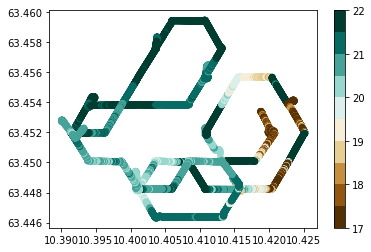

In [15]:
# plot salinity
plt.scatter(lon_auv, lat_auv, c=sal_auv, cmap=get_cmap("BrBG", 10), vmin=17, vmax=22)
plt.colorbar()
plt.show()

# plot temperature
# plt.scatter(lon_auv, lat_auv, c=temp_auv, cmap=get_cmap("RdBu", 20))
# plt.colorbar()
# plt.show()


In [47]:
dataset = np.stack((time_mission, lat_auv, lon_auv, dauv, sal_auv, temp_auv), axis=1)
df = pd.DataFrame(dataset, columns=['timestamp', 'lat', 'lon', 'depth', 'salinity', 'temperature'])
df.to_csv("csv/AUVData.csv", index=False)